# Assignment: Image Inpainting with GANs

Use the given CelebA Dataset(5%) to train GANs for filling in the missing black-box regions. Tasks are as follows:
- Implement a deeper GAN and compare it with a CBAM-enhanced GAN.

- Compare the generated results from both models.

- Experiment with different learning rates (e.g., 0.0002, 0.00005) and observe the impact.

In [1]:
!gdown 1ErheTZEXFRMM1brO1vFb-MAlIw1MDchl
!gdown 1aLXkfCzx8ekGtLw76yF6nFpCmHY-1P6o
!gdown 1IkCEkmUMW3pCo5LUYYeb8nszTbbdD6Up

Downloading...
From: https://drive.google.com/uc?id=1ErheTZEXFRMM1brO1vFb-MAlIw1MDchl
To: /content/celeba_5percent_test.zip
100% 7.03M/7.03M [00:00<00:00, 149MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1aLXkfCzx8ekGtLw76yF6nFpCmHY-1P6o
From (redirected): https://drive.google.com/uc?id=1aLXkfCzx8ekGtLw76yF6nFpCmHY-1P6o&confirm=t&uuid=12e0d08e-f561-4772-bcab-936fc2454f67
To: /content/celeba_5percent_train.zip
100% 56.1M/56.1M [00:00<00:00, 149MB/s]
Downloading...
From: https://drive.google.com/uc?id=1IkCEkmUMW3pCo5LUYYeb8nszTbbdD6Up
To: /content/celeba_5percent_val.zip
100% 7.00M/7.00M [00:00<00:00, 268MB/s]


In [2]:
# unzip dataset
!unzip -q "/content/celeba_5percent_test.zip" -d "/content/test/"
!unzip -q "/content/celeba_5percent_train.zip" -d "/content/train/"
!unzip -q "/content/celeba_5percent_val.zip" -d "/content/val/"


In [3]:
import os

image_path = "/content/train"
image_files = os.listdir(image_path)
print(f"A total of {len(image_files)} images")
print("Image Name:", sorted(image_files)[:5])


A total of 8103 images
Image Name: ['000018.jpg', '000068.jpg', '000090.jpg', '000145.jpg', '000154.jpg']


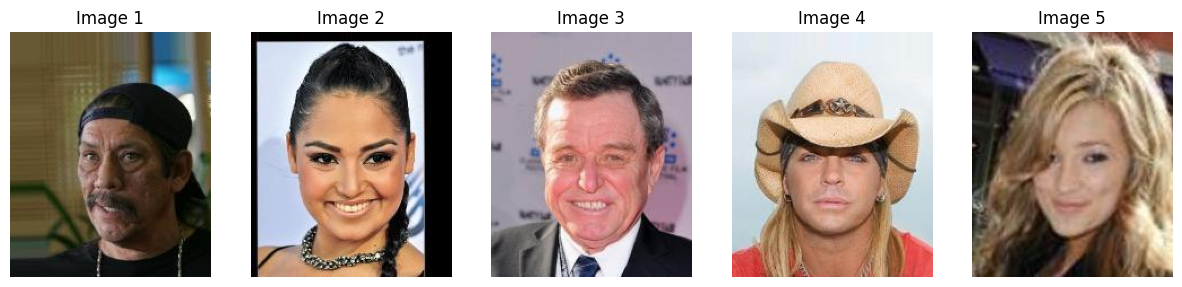

In [4]:
import matplotlib.pyplot as plt
import cv2
import random

random_images = random.sample(image_files, 5)
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, img_file in enumerate(random_images):
    img = cv2.imread(os.path.join(image_path, img_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis("off")
plt.show()


In [ ]:
# Answer your code here


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

torch.Size([32, 3, 64, 64])


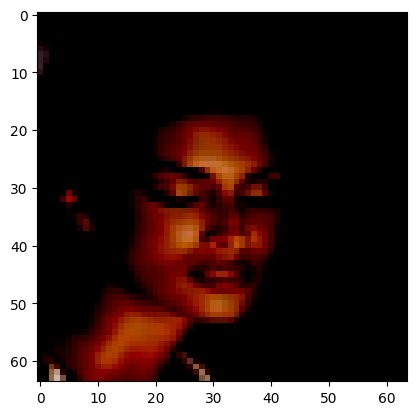

In [7]:


from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, image_path, transform=None):
        self.image_path = image_path
        self.image_files = os.listdir(image_path)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.image_path, img_file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        return image,0

# Example usage
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64,64)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = CustomDataset(image_path="/content/train", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Iterate through the dataloader
for images in train_loader:
    # Your training code here
    plt.imshow(train_dataset[33].__getitem__(0).permute(1,2,0))
    # plt.imshow(images)
    print(images[0].shape) # Example usage: print the shape of the batch
    break # Remove to train on full dataset


In [8]:
class Generator_rgb(nn.Module):
    def __init__(self, input_dim=100, output_channels=3):
        super(Generator_rgb, self).__init__()

        self.net = nn.Sequential(
            # Fully connected layer to reshape input noise into feature maps
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2, inplace=True),

            # First Transposed Convolution
            nn.BatchNorm1d(1024),  # Batch normalization for stability
            nn.Linear(1024, 128 * 8 * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # Reshape the output to (batch_size, 128, 8, 8)
            nn.Unflatten(1, (128, 8, 8)),

            # First 2D Transposed Convolution
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # Second 2D Transposed Convolution
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            # Final 2D Transposed Convolution to get the RGB image of size 64x64
            nn.ConvTranspose2d(32, output_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # To ensure the pixel values are in the range [-1, 1]
        )

    def forward(self, x):
        return self.net(x)

In [9]:

class Discriminator_rgb(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator_rgb, self).__init__()

        self.net = nn.Sequential(
            # Input: (3, 64, 64)
            nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            CBAMAttention(32), # Apply CBAM after the first convolutional layer
            # Output: (32, 32, 32)

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            CBAMAttention(64),
            # Output: (64, 16, 16)

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            CBAMAttention(128),
            # Output: (128, 8, 8)

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            CBAMAttention(256),
            # Output: (256, 4, 4)

            nn.Flatten(),
            nn.Linear(256*4*4, 1),  # Output a single value (real or fake)
            nn.Sigmoid()  # Output between 0 and 1
        )

    def forward(self, x):
        return self.net(x)


In [20]:

class Discriminator_rgb_nocbam(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator_rgb_nocbam, self).__init__()

        self.net = nn.Sequential(
            # Input: (3, 64, 64)
            nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: (32, 32, 32)

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: (64, 16, 16)

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: (128, 8, 8)

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: (256, 4, 4)

            nn.Flatten(),
            nn.Linear(256*4*4, 1),  # Output a single value (real or fake)
            nn.Sigmoid()  # Output between 0 and 1
        )

    def forward(self, x):
        return self.net(x)


In [10]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1)
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

class CBAMAttention(nn.Module):
    def __init__(self, in_channels):
        super(CBAMAttention, self).__init__()
        self.channel_att = ChannelAttention(in_channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = x * self.channel_att(x)
        x = x * self.spatial_att(x)

        return x

In [21]:
# เริ่มต้น Generator และ Discriminator
G = Generator_rgb()
D = Discriminator_rgb_nocbam()

# ใช้ GPU ถ้ามี
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G.to(device)
D.to(device)

# ฟังก์ชันค่าเสียหาย
criterion = nn.BCELoss()

# ตัวปรับแต่ง
lr = 0.0002
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)


Epoch [1/10], G Loss: 3.1783, D Loss: 0.0240


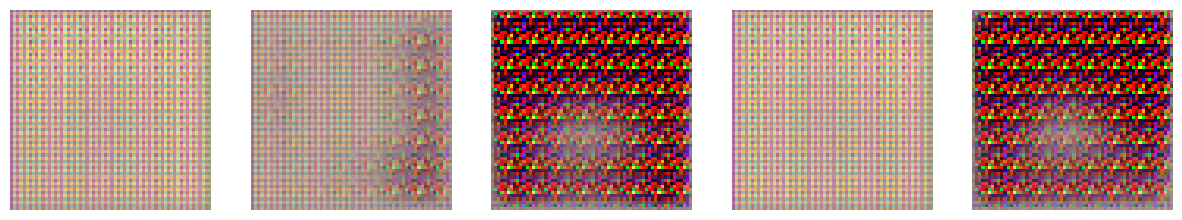

Epoch [2/10], G Loss: 4.0052, D Loss: 0.0466


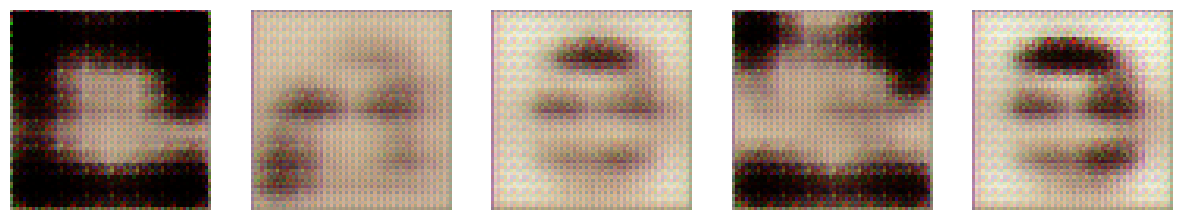

Epoch [3/10], G Loss: 3.1330, D Loss: 0.1661


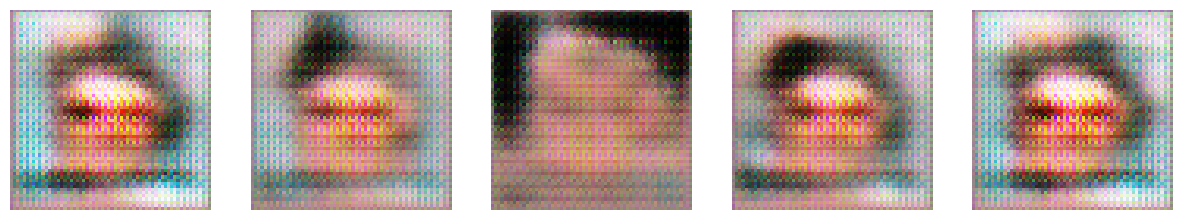

Epoch [4/10], G Loss: 2.2579, D Loss: 0.7450


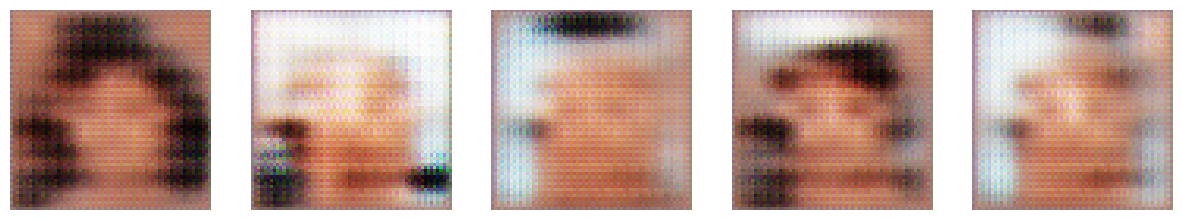

Epoch [5/10], G Loss: 2.4208, D Loss: 0.0827


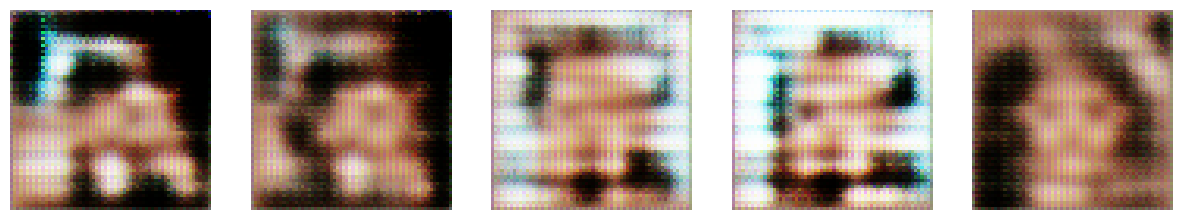

Epoch [6/10], G Loss: 3.0678, D Loss: 0.0996


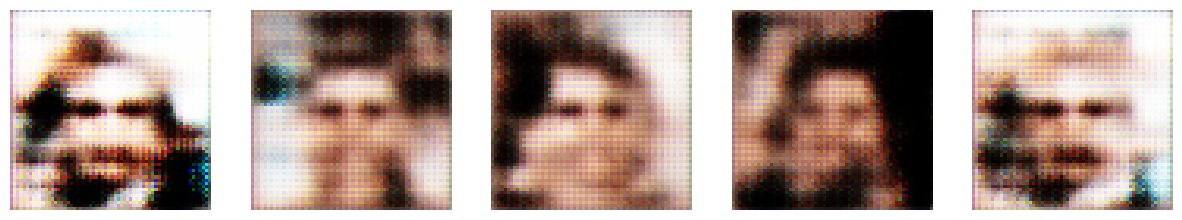

Epoch [7/10], G Loss: 5.4903, D Loss: 0.1422


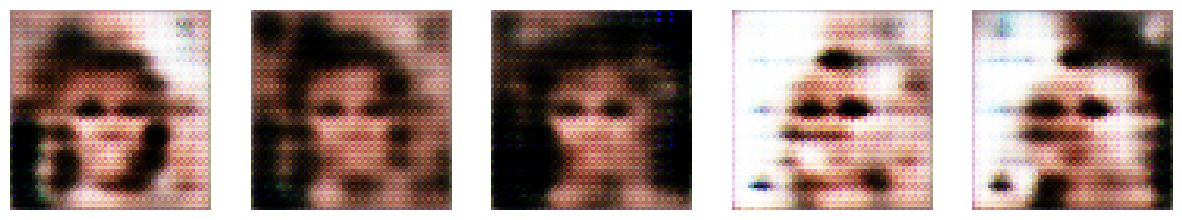

Epoch [8/10], G Loss: 3.1897, D Loss: 0.0366


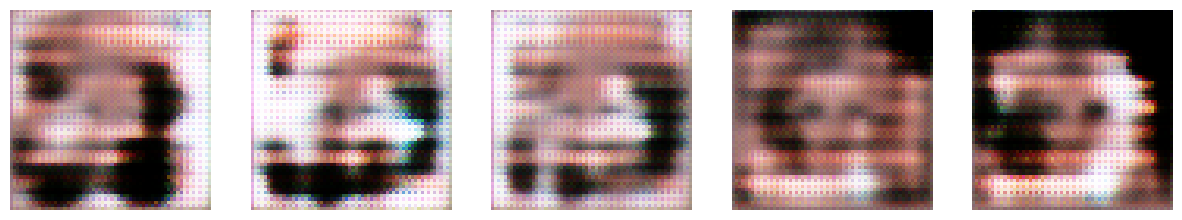

Epoch [9/10], G Loss: 2.2059, D Loss: 0.2099


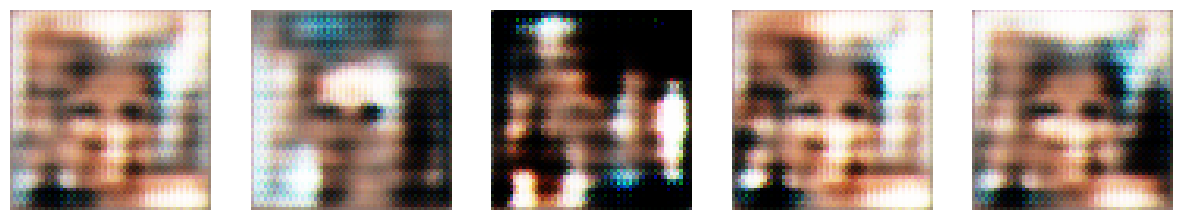

Epoch [10/10], G Loss: 2.5747, D Loss: 0.3677


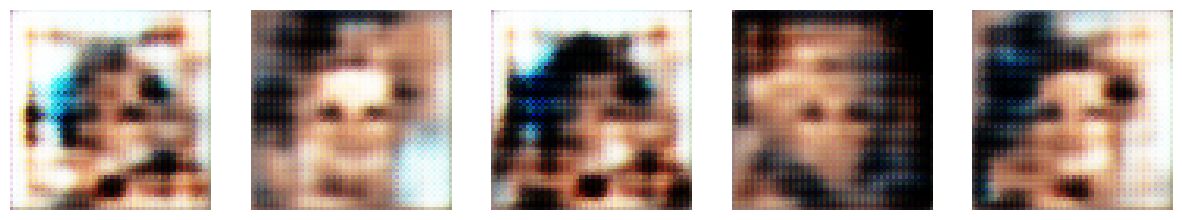

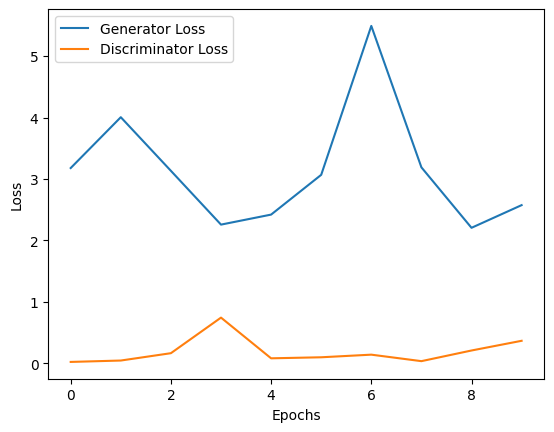

In [22]:
# prompt: adjust code below to train a G D in above and plot every 10 epoch like below

# Training loop
num_epochs = 10
losses_g = []
losses_d = []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        # Adversarial ground truths
        valid = torch.ones(images.size(0), 1, device=device)
        fake = torch.zeros(images.size(0), 1, device=device)

        # Configure input
        real_imgs = images.to(device)


        # -----------------
        #  Train Generator
        # -----------------

        G_optimizer.zero_grad()

        # Sample noise as generator input
        z = torch.randn(images.size(0), 100, device=device)

        # Generate a batch of images
        gen_imgs = G(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = criterion(D(gen_imgs), valid)

        g_loss.backward()
        G_optimizer.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        D_optimizer.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = criterion(D(real_imgs), valid)
        fake_loss = criterion(D(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        D_optimizer.step()

    losses_g.append(g_loss.item())
    losses_d.append(d_loss.item())

    if (epoch+1) % 1 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], G Loss: {g_loss.item():.4f}, D Loss: {d_loss.item():.4f}")
        # Plot generated images
        fig, axes = plt.subplots(1, 5, figsize=(15, 5))
        for i in range(5):
            axes[i].imshow(gen_imgs[i].cpu().detach().permute(1, 2, 0)*0.5 + 0.5)
            axes[i].axis('off')
        plt.show()

# Plot losses
plt.plot(losses_g, label="Generator Loss")
plt.plot(losses_d, label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [11]:
# เริ่มต้น Generator และ Discriminator
G = Generator_rgb()
D = Discriminator_rgb()

# ใช้ GPU ถ้ามี
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G.to(device)
D.to(device)

# ฟังก์ชันค่าเสียหาย
criterion = nn.BCELoss()

# ตัวปรับแต่ง
lr = 0.0002
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)


Epoch [1/10], G Loss: 0.8233, D Loss: 0.8318


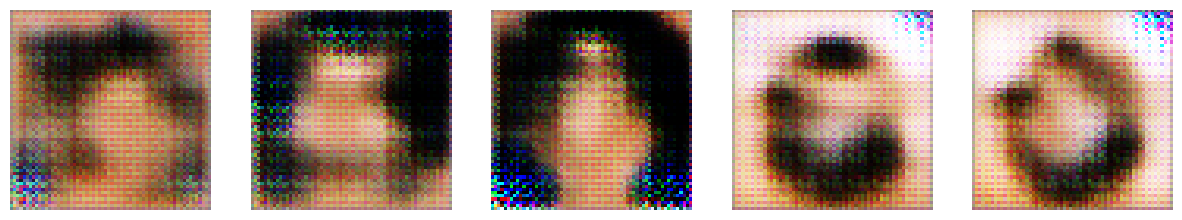

Epoch [2/10], G Loss: 1.4442, D Loss: 0.3076


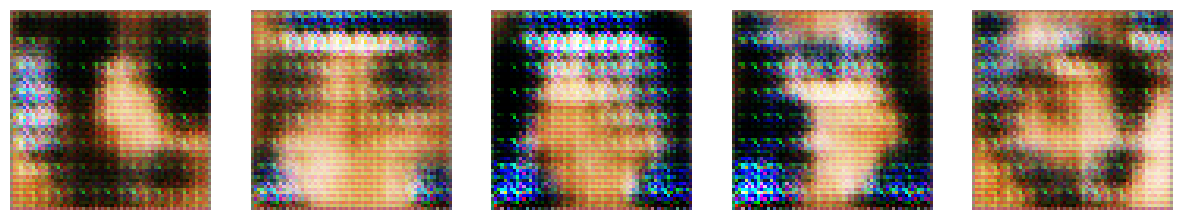

Epoch [3/10], G Loss: 1.3369, D Loss: 0.5221


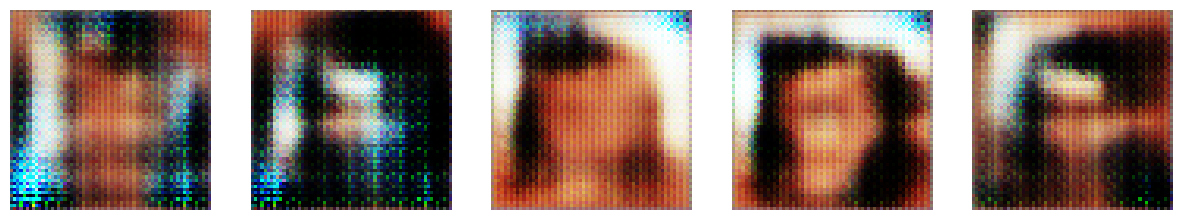

Epoch [4/10], G Loss: 0.6898, D Loss: 0.7961


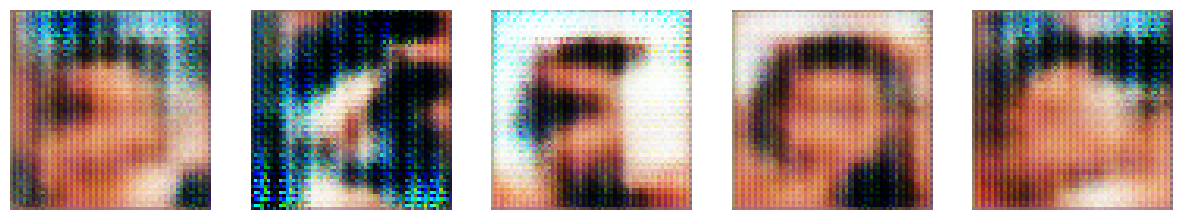

Epoch [5/10], G Loss: 0.8511, D Loss: 0.6414


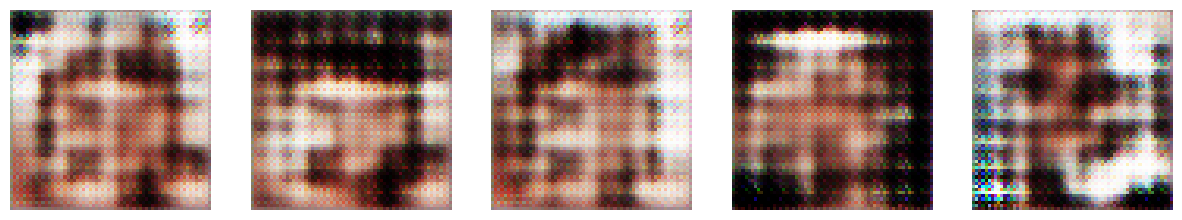

Epoch [6/10], G Loss: 0.7688, D Loss: 0.5738


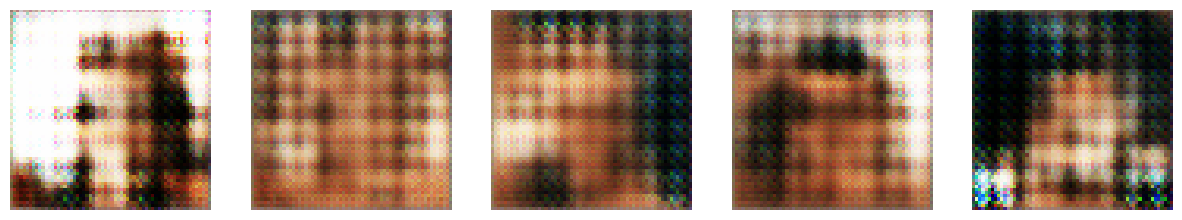

Epoch [7/10], G Loss: 0.6707, D Loss: 0.7219


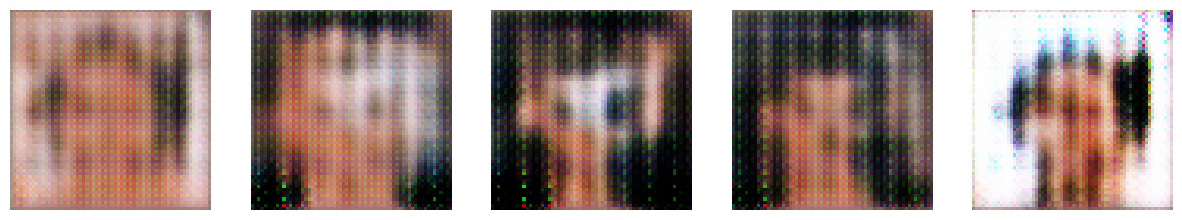

Epoch [8/10], G Loss: 1.1648, D Loss: 0.4232


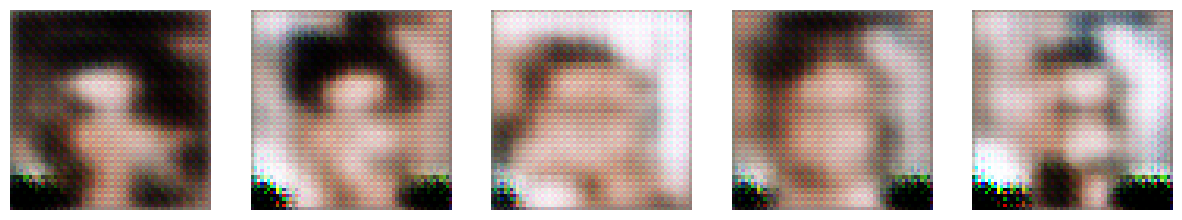

Epoch [9/10], G Loss: 0.8301, D Loss: 0.6117


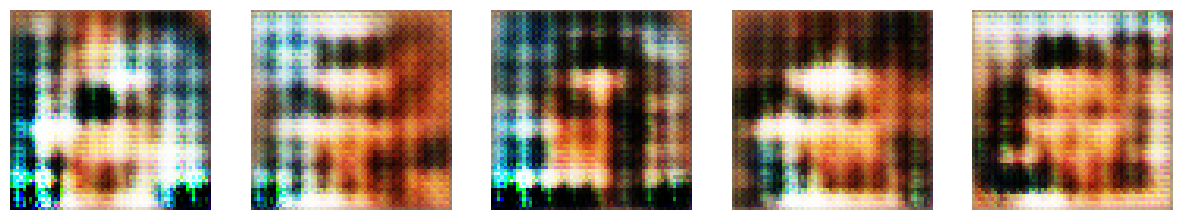

Epoch [10/10], G Loss: 1.5258, D Loss: 0.3746


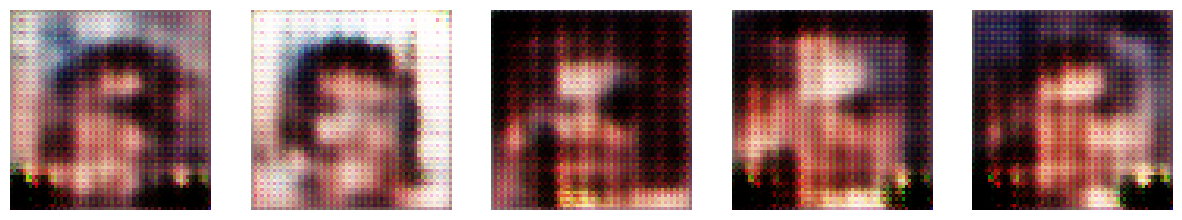

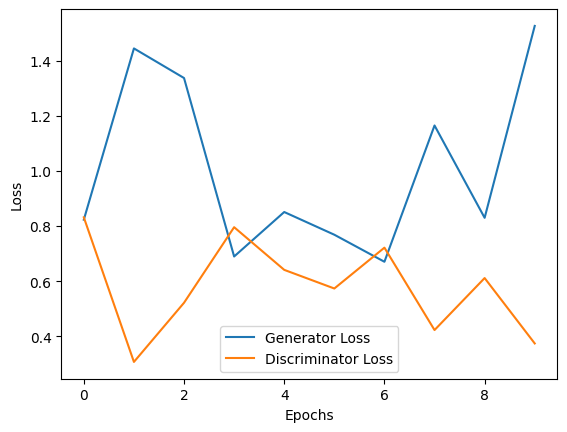

In [14]:
# prompt: adjust code below to train a G D in above and plot every 10 epoch like below

# Training loop
num_epochs = 10
losses_g = []
losses_d = []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        # Adversarial ground truths
        valid = torch.ones(images.size(0), 1, device=device)
        fake = torch.zeros(images.size(0), 1, device=device)

        # Configure input
        real_imgs = images.to(device)


        # -----------------
        #  Train Generator
        # -----------------

        G_optimizer.zero_grad()

        # Sample noise as generator input
        z = torch.randn(images.size(0), 100, device=device)

        # Generate a batch of images
        gen_imgs = G(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = criterion(D(gen_imgs), valid)

        g_loss.backward()
        G_optimizer.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        D_optimizer.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = criterion(D(real_imgs), valid)
        fake_loss = criterion(D(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        D_optimizer.step()

    losses_g.append(g_loss.item())
    losses_d.append(d_loss.item())

    if (epoch+1) % 1 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], G Loss: {g_loss.item():.4f}, D Loss: {d_loss.item():.4f}")
        # Plot generated images
        fig, axes = plt.subplots(1, 5, figsize=(15, 5))
        for i in range(5):
            axes[i].imshow(gen_imgs[i].cpu().detach().permute(1, 2, 0)*0.5 + 0.5)
            axes[i].axis('off')
        plt.show()

# Plot losses
plt.plot(losses_g, label="Generator Loss")
plt.plot(losses_d, label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
##  จากการการทดลองทั้ง 2 แบบ แบบที่มีCBAM lossของทั้ง generator และ discriminator ไม่ต่างกันมาก ซึ่งตรงกันข้ามกับแบบnoCBAM